In [1]:
import os
import pandas as pd
os.environ['TEJAPI_KEY'] = "LOmhsv7309nYr8YE6bENzL0pqMBHrx"
os.environ['TEJAPI_BASE'] = "http://10.10.10.66"
# os.environ['TEJAPI_KEY'] = "LOmhsv7309nYr8YE6bENzL0pqMBHrx" 
# os.environ['TEJAPI_BASE'] = "http://10.10.10.66"

In [2]:
import TejToolAPI 
from zipline.data import bundles
from logbook import Logger, StderrHandler, INFO
# import os
# import pandas as pd

# os.environ['TEJAPI_KEY'] = "your key"
# os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"

bundle_data = bundles.load('tquant')
universe = bundle_data.asset_finder.retrieve_all(bundle_data.asset_finder.equities_sids)   
tickers = [col.symbol for col in universe]

log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('Algorithm')

In [3]:
start = '2020-01-01'
end = '2023-12-31'

os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = ' '.join(tickers) + ' ' + 'IR0001'

!zipline ingest -b tquant

Merging daily equity files:
Currently used TEJ API key call quota 13/100000 (0.01%)
Currently used TEJ API key data quota 171068/10000000 (1.71%)


[2024-03-26 03:12:17.028432] INFO: zipline.data.bundles.core: Ingesting tquant.
[2024-03-26 03:12:28.107914] INFO: zipline.data.bundles.core: Ingest tquant successfully.


In [4]:
from zipline.api import *
from zipline.finance import commission, slippage

def initialize(context):
    set_slippage(slippage.VolumeShareSlippage(volume_limit = 0.025, price_impact = 0.1))
    set_commission(commission.Custom_TW_Commission(min_trade_cost = 20, discount = 1.0, tax = 0.003))
    set_benchmark(symbol('IR0001'))
    context.asset = [symbol(i) for i in tickers]
    context.rules = ['處置股票(Disposition Securities)']
    context.has_ordered = []

In [8]:
def before_trading_start(context, data):
    
    for ticker in context.asset: 
        #非處置股則不下單，且清空帳上股票
        if any(s in data.current(ticker, 'annotation') for s in context.rules) and not ticker in context.has_ordered:
            order(ticker, 1000)
            context.has_ordered.append(ticker)
            
        elif ticker in context.has_ordered:
            order(ticker, 0)
            
        else:
            if ticker in set(context.portfolio.positions.keys()): # 當日前持有部位的股票標的
                order_target(ticker, 0)
                context.has_ordered.remove(ticker)

In [9]:
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar

start_date = pd.Timestamp(start, tz = 'utc')
end_date = pd.Timestamp(end, tz = 'utc')
capital_base = 1e7
calendar_name = 'TEJ'

results = run_algorithm(
    start = start_date,
    end = end_date,
    initialize=initialize,
    bundle='tquant',
    capital_base=capital_base,
#     handle_data = handle_data,
    data_frequency='daily',
    before_trading_start = before_trading_start,
    trading_calendar=get_calendar(calendar_name)
)
results

[2024-03-26 03:13:29.730991]: INFO: earn_dividends: Equity(44 [6415]), cash_dividend amount: 7.47526328, pay_date: 2020-08-14, div_owed: 7475.26328
[2024-03-26 03:13:36.598366]: INFO: earn_dividends: Equity(44 [6415]), cash_dividend amount: 10.464970489999999, pay_date: 2021-08-13, div_owed: 10464.97049
[2024-03-26 03:13:37.039351]: INFO: earn_dividends: Equity(23 [2603]), cash_dividend amount: 2.48660241, pay_date: 2021-09-10, div_owed: 2486.60241
[2024-03-26 03:13:37.313066]: INFO: earn_dividends: Equity(25 [2615]), cash_dividend amount: 1.0, pay_date: 2021-09-29, div_owed: 1000.0
[2024-03-26 03:13:37.315071]: INFO: handle_split: after split: asset: Equity(25 [2615]), amount: 1100, cost_basis: 132.0, last_sale_price: 211.0
[2024-03-26 03:13:37.316067]: INFO: handle_split: returning cash: 6.9
[2024-03-26 03:13:40.661978]: INFO: earn_dividends: Equity(44 [6415]), cash_dividend amount: 17.98027359, pay_date: 2022-04-22, div_owed: 17980.27359
[2024-03-26 03:13:42.374851]: INFO: earn_divi

,period_open,period_close,positions,ending_value,starting_cash,ending_cash,portfolio_value,longs_count,starting_exposure,orders,...,benchmark_volatility,max_leverage,algorithm_period_return,treasury_period_return,alpha,beta,sharpe,sortino,max_drawdown,trading_days
2020-01-02 13:30:00+08:00,2020-01-02 09:01:00+08:00,2020-01-02 13:30:00+08:00,[],0.0,1.000000e+07,1.000000e+07,1.000000e+07,0,0.0,[],...,NaN,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,0.00000,1
2020-01-03 13:30:00+08:00,2020-01-03 09:01:00+08:00,2020-01-03 13:30:00+08:00,[],0.0,1.000000e+07,1.000000e+07,1.000000e+07,0,0.0,[],...,NaN,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,0.00000,2
2020-01-06 13:30:00+08:00,2020-01-06 09:01:00+08:00,2020-01-06 13:30:00+08:00,[],0.0,1.000000e+07,1.000000e+07,1.000000e+07,0,0.0,[],...,0.154829,0.000000,0.000000,0.0,0.000000,0.000000,NaN,NaN,0.00000,3
2020-01-07 13:30:00+08:00,2020-01-07 09:01:00+08:00,2020-01-07 13:30:00+08:00,[],0.0,1.000000e+07,1.000000e+07,1.000000e+07,0,0.0,[],...,0.109481,0.000000,0.000000,0.0,0.000000,0.000000,NaN,NaN,0.00000,4
2020-01-08 13:30:00+08:00,2020-01-08 09:01:00+08:00,2020-01-08 13:30:00+08:00,[],0.0,1.000000e+07,1.000000e+07,1.000000e+07,0,0.0,[],...,0.089596,0.000000,0.000000,0.0,0.000000,0.000000,NaN,NaN,0.00000,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25 13:30:00+08:00,2023-12-25 09:01:00+08:00,2023-12-25 13:30:00+08:00,"[{'sid': Equity(44 [6415]), 'amount': 4000, 'c...",1910086.5,8.846176e+06,8.846176e+06,1.075626e+07,4,1935622.5,[],...,0.180693,0.397379,0.075626,0.0,-0.015886,0.280171,0.216129,0.303210,-0.30933,970
2023-12-26 13:30:00+08:00,2023-12-26 09:01:00+08:00,2023-12-26 13:30:00+08:00,"[{'sid': Equity(44 [6415]), 'amount': 4000, 'c...",1934128.0,8.846176e+06,8.846176e+06,1.078030e+07,4,1910086.5,[],...,0.180643,0.397379,0.078030,0.0,-0.015896,0.280169,0.220760,0.309719,-0.30933,971
2023-12-27 13:30:00+08:00,2023-12-27 09:01:00+08:00,2023-12-27 13:30:00+08:00,"[{'sid': Equity(44 [6415]), 'amount': 4000, 'c...",1997703.0,8.846176e+06,8.846176e+06,1.084388e+07,4,1934128.0,[],...,0.180588,0.397379,0.084388,0.0,-0.014969,0.280386,0.233107,0.327137,-0.30933,972
2023-12-28 13:30:00+08:00,2023-12-28 09:01:00+08:00,2023-12-28 13:30:00+08:00,"[{'sid': Equity(44 [6415]), 'amount': 4000, 'c...",2143504.0,8.846176e+06,8.846176e+06,1.098968e+07,4,1997703.0,[],...,0.180495,0.397379,0.098968,0.0,-0.011597,0.280432,0.261125,0.367022,-0.30933,973


Start date,2020-01-02
End date,2023-12-29
Total months,46
,Backtest
Annual return,2.567%
Cumulative returns,10.29%
Annual volatility,12.215%
Sharpe ratio,0.27
Calmar ratio,0.08
Stability,0.01
Max drawdown,-30.933%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,30.93,2021-11-17,2023-08-25,NaT,NaN
1,7.13,2021-02-18,2021-03-22,2021-05-03,49
2,6.30,2021-07-08,2021-08-19,2021-09-01,40
3,5.32,2021-09-27,2021-10-06,2021-10-29,24
4,5.27,2021-05-07,2021-05-13,2021-05-24,12


Stress Events,mean,min,max
New Normal,0.01%,-3.46%,2.51%


Top 10 long positions of all time,max
sid,
6415,36.98%
2615,2.55%
2603,1.70%
2609,1.64%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
6415,36.98%
2615,2.55%
2603,1.70%
2609,1.64%


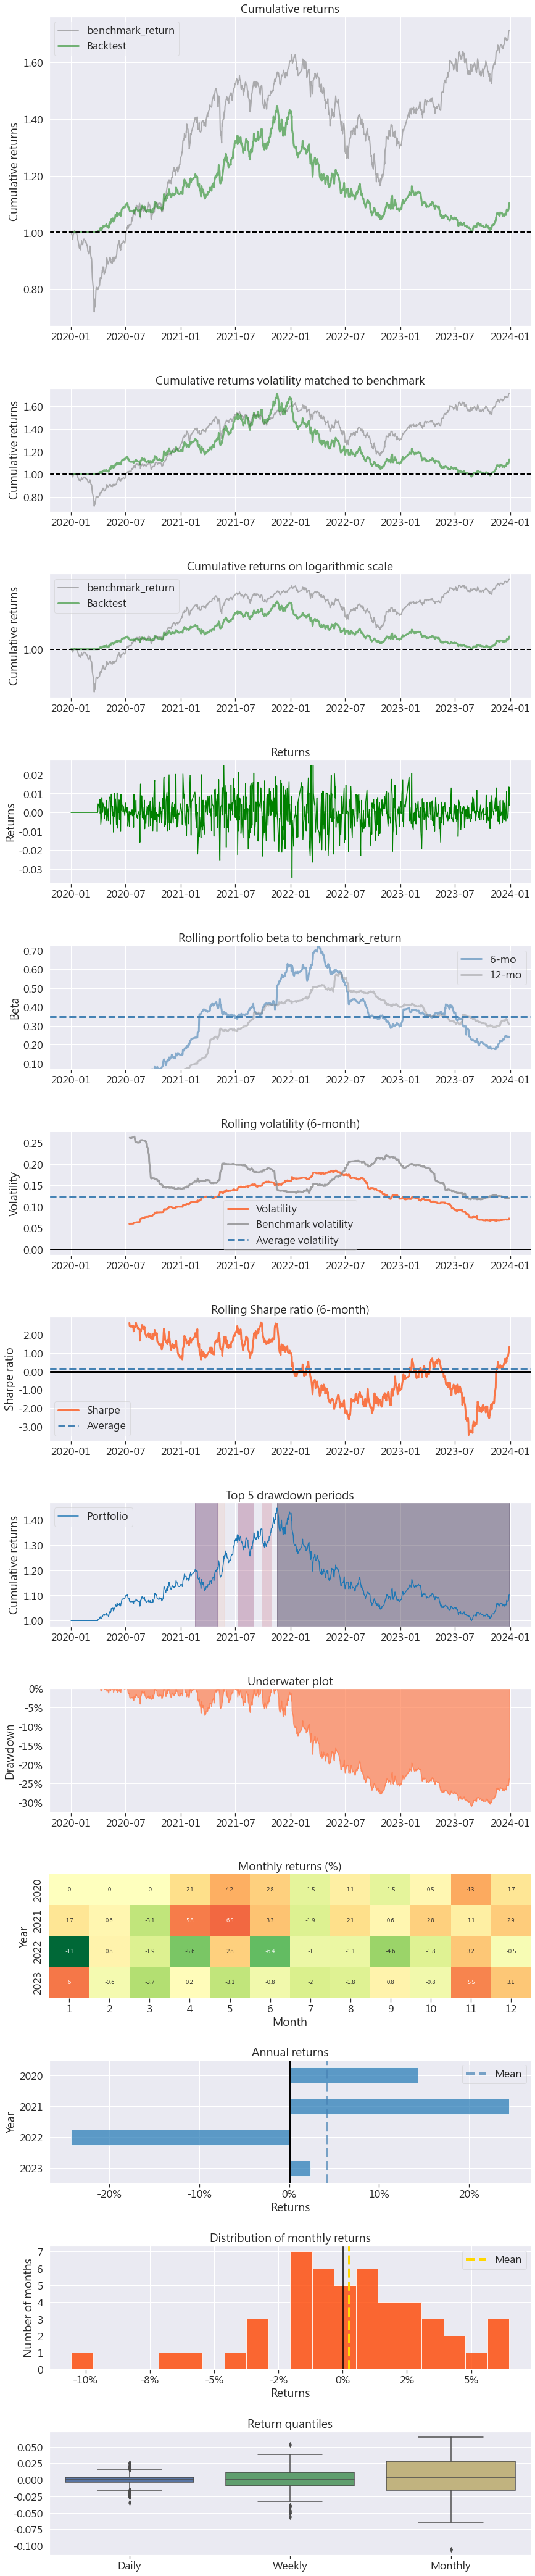

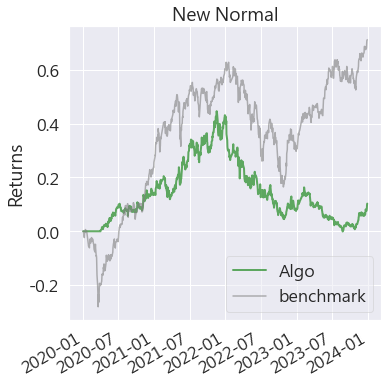

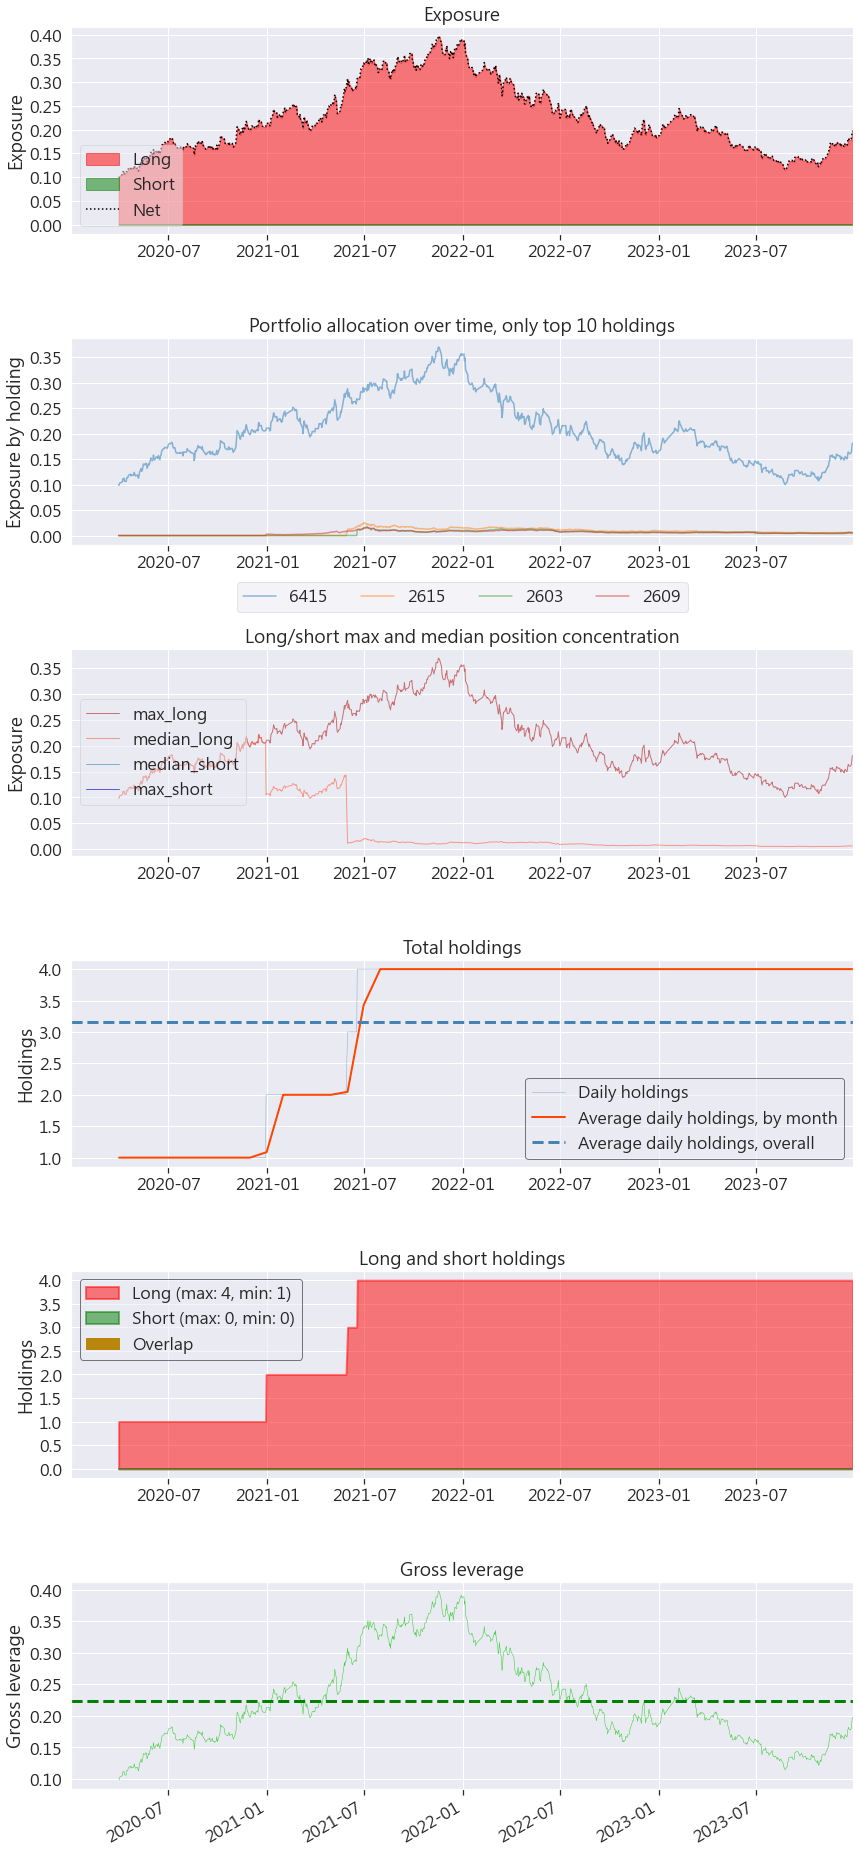

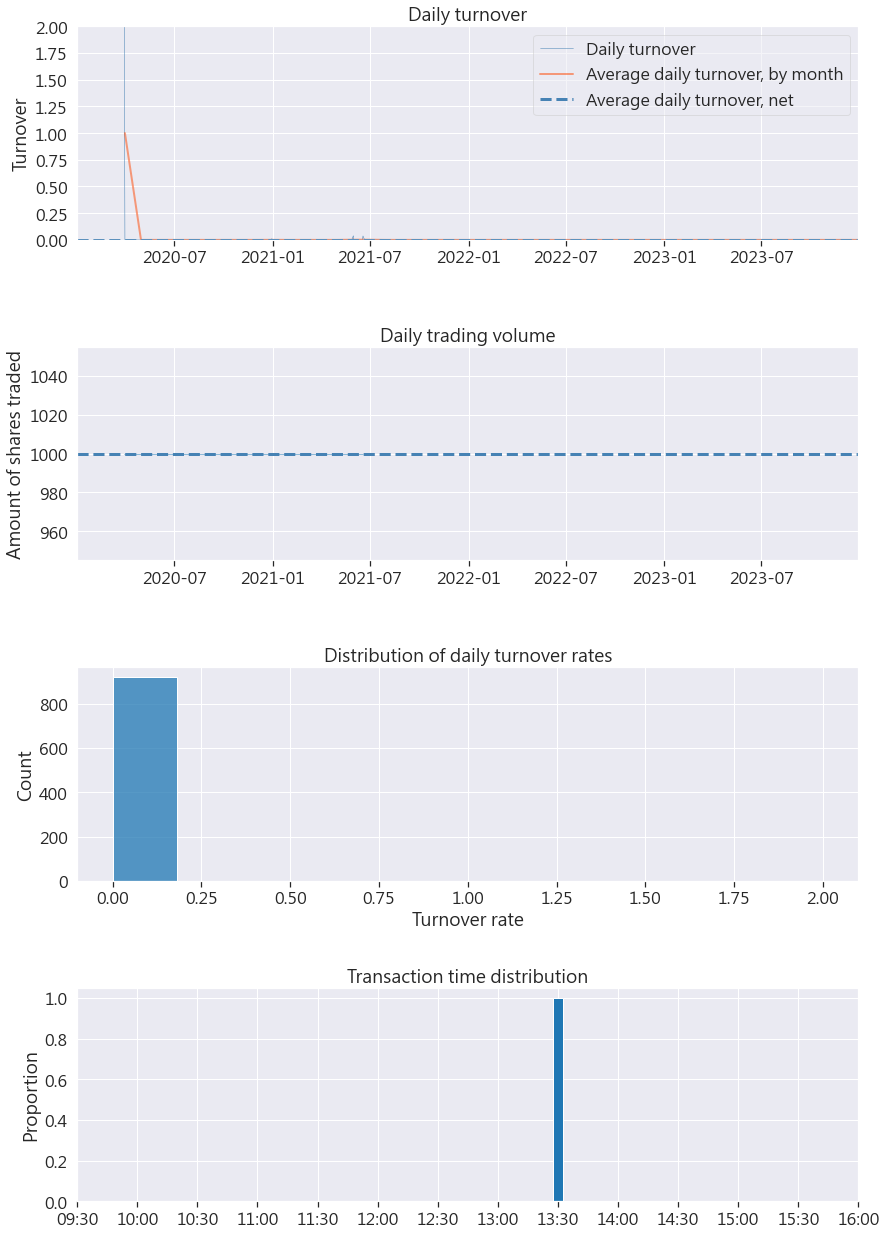

In [10]:
import pyfolio as pf
from pyfolio.utils import extract_rets_pos_txn_from_zipline

returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return

# Creating a Full Tear Sheet
pf.create_full_tear_sheet(returns, positions = positions, transactions = transactions,
                          benchmark_rets = benchmark_rets,
                          round_trips=False)